In [1]:
import random
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

In [2]:
class ProceduralLearningSystem(object):
    def __init__(self,
                 inp_preferred_stimuli, input_scale,
                 categs, sigma_striatal,
                 theta_nmda, theta_ampa, d_base,
                 alpha, beta, gamma,
                 w_max):
        
        self.n_input_units = inp_preferred_stimuli.shape[0]  # inp_preferred_stimuli is expected to have examples in rows and features in columns
        self.inp_preferred_stimuli = inp_preferred_stimuli
        self.input_scale = input_scale
        
        self.categs = categs # Tuple of categories' names; e.g., ("A", "B")
        self.n_striatal = len(categs)
        self.sigma_striatal = sigma_striatal
        
        self.weights = 0.001 + 0.0025 * np.random.uniform(size=(self.n_input_units, self.n_striatal))
        
        self.theta_nmda = theta_nmda
        self.theta_ampa = theta_ampa
        self.d_base = d_base
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        
        self.w_m = w_max
        
        self.prev_obt_r = 0.0
        self.prev_pred_r = 0.0
        
        # Confidence
        self.confidence_in_prediction = None
        self.max_h_P = 0
        
    def compute_inp_activations(self, stimulus):
        return np.array(list(map(self.compute_activation, 
                   self.inp_preferred_stimuli, 
                   np.tile(stimulus, (self.n_input_units, 1)))))
    
    def compute_activation(self, K, stimulus):
        distance = self.compute_distance(K, stimulus)
        return np.exp(-(distance ** 2) / self.input_scale)
        
    def compute_distance(self, K, stimulus):
        return np.sum(np.sqrt((K - stimulus) ** 2))
    
    def activate_striatal_units(self, inp_activations):
        perturbs = np.random.normal(scale=self.sigma_striatal, size=(self.n_input_units, self.n_striatal))
        striat_activations = np.zeros((self.n_striatal, ))
        for j in range(self.n_striatal):
            striat_activations[j] = np.sum(inp_activations * self.weights[:, j] + perturbs[:, j])
        return striat_activations
    
    def resp_from_striatal(self, striat_activations):
        winner_ind = np.argmax(striat_activations)
        return self.categs[winner_ind]
        
    def update_weights(self, inp_acts, striat_acts, dopamine):
        w_m = self.w_m # np.max(self.weights)
        for i in range(self.n_input_units):
            for j in range(self.n_striatal):
                self.weights[i, j] = (
                    self.weights[i, j] + 
                    self.alpha * inp_acts[i] 
                        * self.striat_minus_nmda(striat_acts[j]) * self.dop_minus_d_base(dopamine) 
                        * self.wmax_minus_w(self.weights[i, j]) - 
                    self.beta * inp_acts[i] 
                        * self.striat_minus_nmda(striat_acts[j]) * self.d_base_minus_dop(dopamine) 
                        * self.weights[i, j] -
                    self.gamma * inp_acts[i] 
                        * self.nmda_striat_minus_ampa(striat_acts[j]) 
                        * self.weights[i, j]
                )
    
    def compute_dopamine(self, response, real_categ):
        if real_categ == None:
            obt_r = 0.0 # Negative rpe?
        else:
            if response == real_categ:
                obt_r = 1.0
            else:
                obt_r = -1.0
        pred_r = self.prev_pred_r + 0.025 * (self.prev_obt_r - self.prev_pred_r)
        
        rpe = obt_r - pred_r
        if rpe > 1.0:
            dopamine = 1
        elif rpe > -0.25 and rpe <= 1.0:
            dopamine = 0.2 + 0.8 * rpe
        else:
            dopamine = 0
            
        self.prev_obt_r = obt_r
        self.prev_pred_r = pred_r
        return dopamine
    
    
    def striat_minus_nmda(self, striat_activation):
        difference = striat_activation - self.theta_nmda
        if difference > 0:
            return difference
        else:
            return 0
        
    def dop_minus_d_base(self, dopamine):
        difference = dopamine - self.d_base
        if difference > 0:
            return difference
        else:
            return 0
        
    def d_base_minus_dop(self, dopamine):
        difference = self.d_base - dopamine
        if difference > 0:
            return difference
        else:
            return 0
        
    def nmda_minus_striat(self, striat_activation):
        difference = self.theta_nmda - striat_activation
        if difference > 0:
            return difference
        else:
            return 0    
    
    def nmda_striat_minus_ampa(self, striat_activation):
        difference = self.nmda_minus_striat(striat_activation) - self.theta_ampa
        if difference > 0:
            return difference
        else:
            return 0 
    
    def wmax_minus_w(self, w):
        difference = self.w_m - w
        if difference > 0:
            return difference
        else:
            return 0
    
    
    def process_stimulus(self, stimulus, real_categ):
        inp_activations = self.compute_inp_activations(stimulus)
        striat_activations = self.activate_striatal_units(inp_activations)
        self._update_confidence(striat_activations)
        response = self.resp_from_striatal(striat_activations)
        self.current_prediction = response
        is_correct = response == real_categ
        
        dopamine = self.compute_dopamine(response, real_categ)
        self.update_weights(inp_activations, striat_activations, dopamine)       
        
        return is_correct
    
    def _update_confidence(self, striat_activations):
        # p. 76, Eq. (14)
        S_A, S_B = striat_activations
        h_P = abs(S_A - S_B)
        
        # Normalize by the historical maximum value
        if h_P > self.max_h_P:
            self.max_h_P = h_P
            self.confidence_in_prediction = h_P
        else:
            self.confidence_in_prediction = h_P / self.max_h_P

In [3]:
stimuli = list(product((0, 1), repeat=4))
n_stim = len(stimuli)

rb_categs = ["B" if stim[0] == 1 else "A" for stim in stimuli]

ii_categs = ["B" if sum(stim[:3]) > 1.5 else "A" for stim in stimuli]

In [4]:
n_blocks = 20

pl_system = ProceduralLearningSystem(inp_preferred_stimuli=np.array(stimuli), input_scale=0.01,
                                     categs=("A", "B"), sigma_striatal=0.0125,
                                     theta_nmda=0.0022, theta_ampa=0.01, d_base=0.2,
                                     alpha=0.65, beta=0.19, gamma=0.02,
                                     w_max=1.0)

blocks_ii = []
for _iter in range(n_blocks):
    block_hits = []
    for ind in random.sample(range(n_stim), n_stim):
        block_hits.append(pl_system.process_stimulus(stimuli[ind], ii_categs[ind]))
    blocks_ii.append(sum(block_hits) / float(n_stim))

In [5]:
pl_system = ProceduralLearningSystem(inp_preferred_stimuli=np.array(stimuli), input_scale=0.01,
                                     categs=("A", "B"), sigma_striatal=0.0125,
                                     theta_nmda=0.0022, theta_ampa=0.01, d_base=0.2,
                                     alpha=0.65, beta=0.19, gamma=0.02,
                                     w_max=1.0)

blocks_rb = []
for _iter in range(n_blocks):
    block_hits = []
    for ind in random.sample(range(n_stim), n_stim):
        block_hits.append(pl_system.process_stimulus(stimuli[ind], rb_categs[ind]))
    blocks_rb.append(sum(block_hits) / float(n_stim))

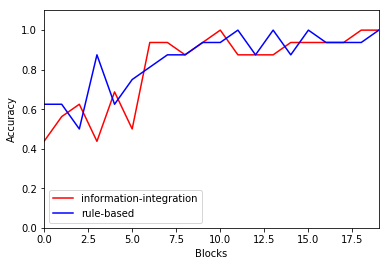

In [6]:
plt.plot(blocks_ii, 'r', label='information-integration')
plt.plot(blocks_rb, 'b', label='rule-based')

plt.xlabel('Blocks')
plt.ylabel('Accuracy')

plt.axis([0, n_blocks - 1, 0, 1.1])
plt.legend()

plt.show()

In [7]:
print("prev_pred_r:", pl_system.prev_pred_r)
print("prev_obt_r:", pl_system.prev_obt_r)
print("\nWeights:\n", pl_system.weights)

prev_pred_r: 0.9240354869529476
prev_obt_r: 1.0

Weights:
 [[0.43090742 0.03297754]
 [0.42033536 0.08384758]
 [0.27754005 0.06534731]
 [0.17115114 0.10185405]
 [0.55038304 0.17704451]
 [0.20291875 0.06134561]
 [0.69869672 0.08343535]
 [0.44988807 0.01636582]
 [0.05636826 0.24108993]
 [0.03890827 0.17551317]
 [0.03870223 0.46981707]
 [0.14184662 0.30336635]
 [0.06966282 0.35992457]
 [0.06040122 0.31713078]
 [0.10067756 0.36243435]
 [0.03398547 0.08234261]]
